In [121]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pymap3d as pm
import datetime
import pandas as pd
from spacetrack import SpaceTrackClient
from scipy.optimize import root

In [122]:
def ecef2eci(x,y,z,time):
    x_eci, y_eci, z_eci = pm.ecef2eci(x, y, z, time=time, use_astropy=True)
    return x_eci, y_eci, z_eci 

In [123]:
def find_sat(i, Ω, e, ω, M, n, s, time, sat_t):
    position = []
    for elem in time:
        Δt = (elem - sat_t).seconds / 3600 / 24
        # средняя аномалия для выбранной даты
        M_average = M + 360 * (n * Δt - int(n * Δt) - int((M + 360 * (n * Δt - int(n * Δt)))/360))
        M_average = M_average * math.pi / 180  # перевод в радианы 
        # E - e sinE = M
        E = root(lambda E: E - e * np.cos(E) - M_average, 0).x[0]
        # находим истинную аномалию [-π;π]
        v = 2 * np.arctan2(np.sqrt((1+e)/(1-e)) * np.tan(E/2),1)
        v = v * 180 / math.pi  # перевод в градусы 
        # грав. параметр земли км^3/день^2
        μ = 2.9755363405824e15
        # большая полуось орбиты в км
        a = np.cbrt(μ / ((2 * np.pi * n) ** 2))  
        # растояние до перицентра в км
        P = a * (1 - e)
        # мгновенное геоцентрическое растояние в км
        r = (P * (1+e)) / (1 + e * np.cos(v))
        J_2 = 1.0826267e-3
        a1 = a / 6378.137
        # Вычисляем параметры которые понадобятся для учёта прецессии линии узлов и линии апсид
        d1 = (3 * J_2 * (6378.137**2) * (3 * (np.cos(i)**2) - 1 )) / (4 * a1**2 * np.cbrt((1-e**2)**2))
        a0 = -a1 * ((134 * d1**3/81) + d1**2 + d1/3 - 1)
        p0 = a0 * (1 - e**2)
        # пересчет ДВУ на момент времени
        Ω1 = Ω + 360 * (-3*J_2*(6378.137**2)*n*np.cos(i))*Δt/(2*p0**2)
        ω1 = ω + 360 * (-3*J_2*(6378.137**2)*n*(5*np.cos(i)**2 - 1))*Δt/(4*p0**2)
        u = ω1 + v
        """
        Плоскость орбиты КА, экваториальная плоскость и плоскость мгновенного меридиана КА образуют сферический прямоугольный треугольник (рис. 2), из которого, используя формулы сферической тригонометрии, можно определить разницу долгот Δα ‒
        разницу между геоцентрическим прямым восхождением КА αg и долготой восходящего
        узла α :
        """
        # прямое восхождение КА
        ω_g = ω1 + np.arccos(np.cos(u)/(np.sqrt(1-np.sin(i)**2 * np.sin(u)**2)))
        # склонение КА
        δ = np.sign(np.sin(u)) * np.arccos(np.cos(u)/np.cos(np.arccos(np.cos(u)/(np.sqrt(1-np.sin(i)**2 * np.sin(u)**2)))))
        # координаты в геоцентрической экватериальной СК
        x_sat_g = r * np.cos(ω_g) * np.cos(δ)
        y_sat_g = r * np.sin(ω_g) * np.cos(δ)
        z_sat_g = r * np.sin(δ)
        position.append([x_sat_g, y_sat_g, z_sat_g])
    return position

getting and parsing TLE data:
https://gis-lab.info/qa/python-orbital-tracks.html

In [124]:
sat_id = {15: 25338, 16: 26536, 17: 27453, 18: 28654, 19: 33591}
# getting TLE data #
n = int(input("NOAA:"))
USERNAME = "radmir-daminov@mail.ru"
PASSWORD = "!9vehaNGZrVuFqj"
st = SpaceTrackClient(identity=USERNAME, password=PASSWORD)
data = st.tle_latest(norad_cat_id=sat_id[n], orderby='epoch desc', limit=1, format='tle')

NOAA:19


In [125]:
start_lesson = datetime.datetime(2020, 9, 30, 15, 45)
end_lesson = datetime.datetime(2020, 9, 30, 17, 5)
date_generated = pd.date_range(start=start_lesson, end=end_lesson, freq='1min')

In [126]:
# parsing TLE data #
i = float(data[78:86])  # Наклонение в градусах
Ω = float(data[87:96])  # Долгота восходящего узла в градусах
e = float("0." + data[96:103])  # Эксцентриситет
ω = float(data[104:112])  # Аргумент перицентра в градусах
M = float(data[113:121])  # Средняя аномалия в градусах
n = float(data[122:133])  # Частота обращения (оборотов в день) (среднее движение) [виток/день]
s = int(86400*float("0." + data[24:32]))
sat_t = datetime.datetime(int("20" + data[18:20]), 1, 1) + datetime.timedelta(days=int(data[20:23]) - 1) + datetime.timedelta(seconds=s)  # Время эпохи

https://en.wikipedia.org/wiki/Geographic_coordinate_conversion#From_geodetic_to_ECEF_coordinates

In [127]:
# LK
latitude = 55.928
longitude = 37.521
altitude = (195 + 50)/1000 # in km

# LLA(geodetic) to ECEF #
rad_lat = latitude * (math.pi / 180.0)
rad_lon = longitude * (math.pi / 180.0)
a = 6371  # equatorial radius
b = 6356.8  # polar radius
e2 = 1 - (b**2)/(a**2) 
N = a / np.sqrt(1 - (e * np.sin(latitude)**2))
x = (N + altitude) * math.cos(rad_lat) * math.cos(rad_lon)
y = (N + altitude) * math.cos(rad_lat) * math.sin(rad_lon)
z = (N * (1 - e2) + altitude) * math.sin(rad_lat)

In [128]:
satellite = find_sat(i, Ω, e, ω, M, n, s, date_generated, sat_t)
thettas = []
d = []
elevations = []
for i in range(len(satellite)):
    r = []
    x,y,z = ecef2eci(x,y,z,date_generated[i])
    r.append(satellite[i][0] - x)
    r.append(satellite[i][0] - y)
    r.append(satellite[i][0] - z)
    distance = np.linalg.norm(r)
    Z = np.arccos((r[0]/distance * np.cos(rad_lat) * np.cos(rad_lon)) + (r[1]/distance * np.cos(rad_lat) * np.sin(rad_lon)) + (r[2]/distance * np.sin(rad_lat)))
    Z = Z * 180/math.pi
    elevation = 90 - Z
    arg1 = -r[0]/distance * np.sin(rad_lon) + r[1]/distance * np.cos(rad_lon)
    arg2 = (-r[0]/distance * np.sin(rad_lat) * np.cos(rad_lon)) - (r[1]/distance * np.sin(rad_lat) * np.sin(rad_lon)) + (r[2]/distance * np.cos(rad_lat))
    azimuth = np.arctan2(arg1,arg2)
    azimuth = azimuth * 180/math.pi
    thettas.append(azimuth)
    d.append(distance)
    elevations.append(elevation)

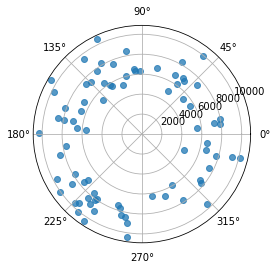

In [129]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='polar')
c = ax.scatter(thettas, d, alpha=0.75)

In [130]:
edge = 10 #deg
for i in range(len(satellite)):
    if elevations[i] <= edge and d[i] <= 200 :
        print(date_generated[i])